In [2]:
import sim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
from tqdm import tqdm

In [3]:
def r_t(D,z,t,x_1,y_1):
    mul = np.sqrt((D**2) - (z**2))
    x = x_1 + mul*np.cos(t)
    y = y_1 + mul*np.sin(t)
    r = np.sqrt((x**2) + (y**2) + (z**2))
    return r

class Uniform(object):
    @staticmethod
    def rho(r,p0,radius=1):
        if r > radius:
            return 0
        else:
            return p0
    
    @staticmethod
    def mass(D,x_1,y_1,p0,radius):
        def func(t,z):
            return Uniform.rho(r_t(D,z,t,x_1,y_1),p0,radius)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,radius=1,M=1):
        if D == 0:
            return 0
        p0 = M/((4/3) * np.pi * (radius**2))
        mass = Uniform.mass(D,x_1,y_1,p0,radius)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = Uniform.phi(x,ri,0,1,1,1) * step
        return out

class NFW(object):
    @staticmethod
    def rho(r,p0,Rs):
        if r > 3:
            return 0
        return p0 / ((r/Rs) * (1 + (r/Rs))**2)
    
    @staticmethod
    def mass(D,x_1,y_1,p0,Rs):
        def func(t,z):
            return NFW.rho(r_t(D,z,t,x_1,y_1),p0,Rs)
        integral = scipy.integrate.dblquad(func,-D,D,0,2*np.pi,epsrel=1e-1)
        return D * integral[0],integral[1]
    
    @staticmethod
    def phi(D,x_1,y_1=0,G=1,c=5,Mvir=1):
        if D == 0:
            return 0
        Rs = 1/c
        p0 = Mvir / (4 * np.pi * (Rs**3) * (np.log(1+c) - (c/(1+c))))
        mass = NFW.mass(D,x_1,y_1,p0,Rs)
        return ((-G * mass[0]) / D)
    
    @staticmethod
    def phis(xs,ri,c=5,Mvir=1):
        out = np.zeros_like(xs)
        step = xs[1] - xs[0]
        for idx,x in enumerate(xs):
            out[idx] = NFW.phi(x,ri,c=c,Mvir=Mvir) * step
        return out

def bin_phi(phis,dists,bins):
    start = bins[:-1]
    end = bins[1:]
    step = bins[1]-bins[0]
    xs = (end-start)/2 + start
    ys = []
    ahh = 0
    if len(phis) > len(dists):
        phis = phis[:-1]
    for idx in range(len(start)):
        temp_dists = dists[dists > start[idx]]
        temp_phis = phis[dists > start[idx]]
        temp_phis = temp_phis[temp_dists <= end[idx]]
        ahh += len(temp_phis)
        ys.append(np.sum(temp_phis))
    return np.array(ys)

In [45]:
f8_dists = []
f2_dists = []

ray = sim.utils.ray(np.array([1,0,0]),3,2)

Mvir = 1
c = 5

n = 25
initial_df = sim.halos.Sample.NFW(2**n,c=c,Mvir=Mvir,a=3)

ns = []

masses = []

dists = []
for downsample in tqdm(2**(np.arange(0,n-6))):
    
    df = sim.halos.downsample(initial_df,downsample)
    masses.append(df.iloc[0]["mass"])

    n = len(df.index)
    ns.append(n)

    f8_dists.append(sim.distances.cudaDist(ray,df,precision="f8"))
    f2_dists.append(sim.distances.cudaDist(ray,df,precision="f2"))
    
print(ns)


100%|██████████| 19/19 [01:33<00:00,  4.95s/it]

[33554432, 16777216, 8388608, 4194304, 2097152, 1048576, 524288, 262144, 131072, 65536, 32768, 16384, 8192, 4096, 2048, 1024, 512, 256, 128]


In [56]:
ys = []
ys2 = []
for f2,f8 in zip(f2_dists,f8_dists):
    distf2 = (1/f2[0]).astype(np.float16)
    distf8 = 1/f8[0]
    ys2.append(np.sum(distf2 == np.inf))
    distf2[distf2 == np.inf] = 0
    diff = np.abs((distf8) - (distf2)) / distf8
    ys.append(np.mean(diff))

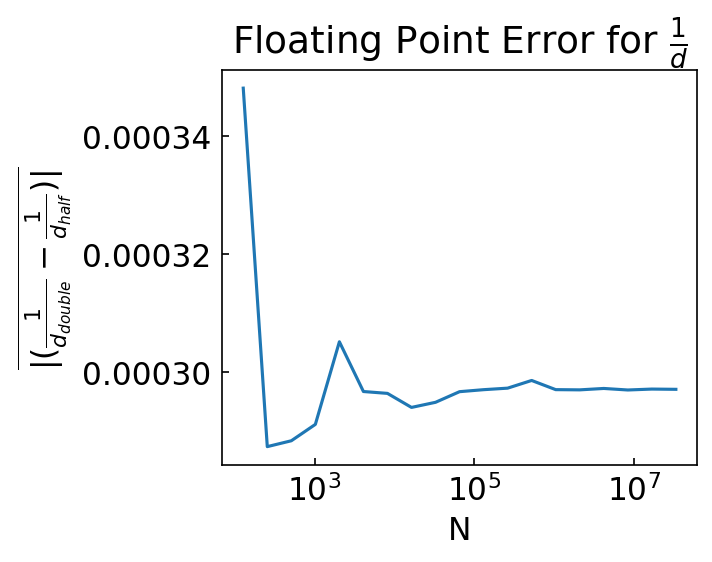

In [63]:
sim.pretty_plots.plot_pretty()
plt.title(r"Floating Point Error for $\frac{1}{d}$")
plt.plot(ns,ys)
plt.xscale('log')
plt.ylabel(r"$\overline{|(\frac{1}{d_{double}} - \frac{1}{d_{half}})|}$")
plt.xlabel("N")
plt.tight_layout()
plt.savefig("floatingpointerror1_d.jpg")
plt.show()

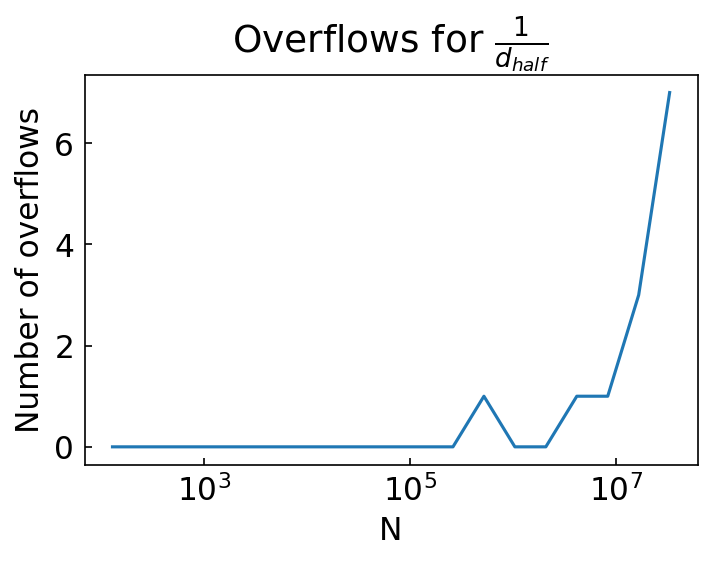

In [62]:
sim.pretty_plots.plot_pretty()
plt.title(r"Overflows for $\frac{1}{d_{half}}$")
plt.plot(ns,np.array(ys2))
plt.xscale('log')
plt.ylabel('Number of overflows')
plt.xlabel("N")
plt.tight_layout()
plt.savefig("overflows1_d.jpg")
plt.show()